# Plotting Choropleths from Shapefiles in R with ggmap: Toronto Neighbourhoods by Population

In [18]:
# Requirements
#install.packages('maptools')
#install.packages('rgeos')
#install.packages('gpclib')
#install.packages('rgdal')
#install.packages('RColorBrewer')
#install.packages('ggplot2')
#install.packages('ggmap')

library(maptools)
library(rgeos)
library(gpclib)
library(rgdal)
library(RColorBrewer)
library(ggplot2)
library(ggmap)

ℹ Google's Terms of Service: <https://mapsplatform.google.com>

ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.



### Introduction

So, I’m not really a geographer. But any good analyst worth their salt will eventually have to do some kind of mapping or spatial visualization. Mapping is not really a forte of mine, though I have played around with it some in the past.

I was working with some shapefile data a while ago and thought about how its funny that so much of spatial data is dominated by a format that is basically proprietary. I looked around for some good tutorials on using shapefile data in R, and even so it took me a while to figure it out, longer than I would have thought.

So I thought I’d put together a simple example of making nice choropleths using R and ggmap. Let’s do it using some nice shapefile data of my favourite city in the world courtesy of the good folks at Toronto’s Open Data initiative.

### Background
We’re going to plot the shapefile data of Toronto’s neighbourhoods boundaries in R and mash it up with demographic data per neighbourhood from Wellbeing Toronto.

We’ll need a few spatial plotting packages in R (ggmap, rgeos, maptools).

Also the shapefile originally threw some kind of weird error when I originally tried to load it into R, but it was nothing loading it into QGIS once and resaving it wouldn’t fix. The working version is available on the github page for this post.

### Analysis

First let’s just load in the shapefile and plot the raw boundary data using maptools. What do we get?

Warning message:
"OGR support is provided by the sf and terra packages among others"
Warning message:
"OGR support is provided by the sf and terra packages among others"
Warning message:
"OGR support is provided by the sf and terra packages among others"
Warning message:
"OGR support is provided by the sf and terra packages among others"
Warning message:
"OGR support is provided by the sf and terra packages among others"
Warning message:
"OGR support is provided by the sf and terra packages among others"
Warning message:
"OGR support is provided by the sf and terra packages among others"


OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\myles\Desktop\toronto_neighbourhoods\NEIGHBORHOODS_WGS84_2.shp", layer: "NEIGHBORHOODS_WGS84_2"
with 140 features
It has 2 fields


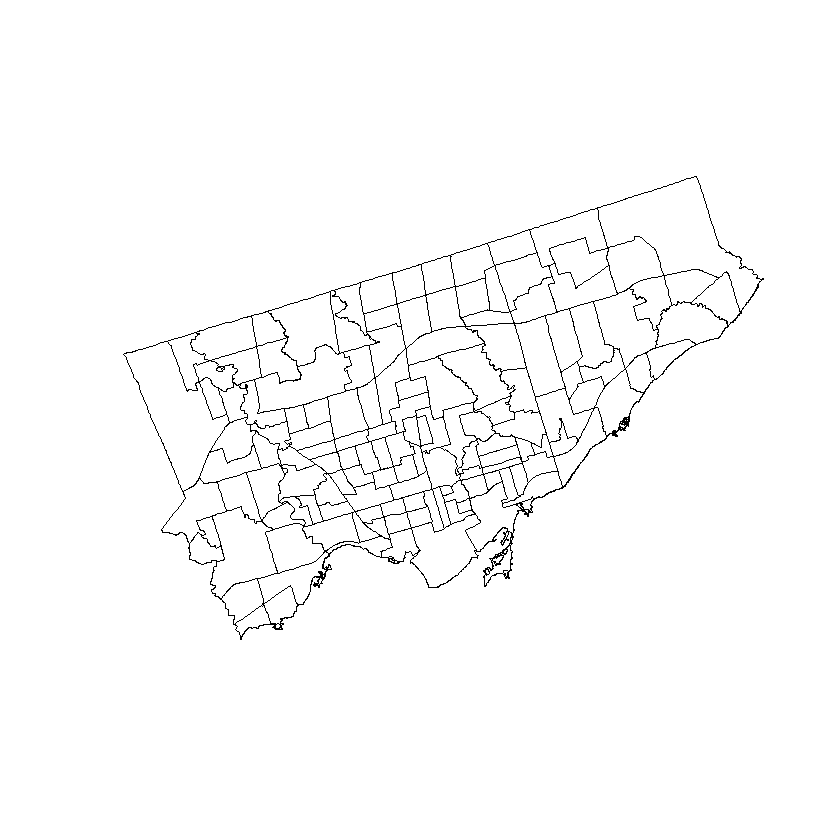

In [19]:
# Read the neighborhood shapefile data and plot
shpfile <- "NEIGHBORHOODS_WGS84_2.shp"
sh <- readOGR(shpfile)
plot(sh)

This just yields the raw polygons themselves. Any good Torontonian would recognize these shapes. There's some maps like these with words squished into the polygons hanging in lots of print shops on Queen Street. Also as someone pointed out to me, most T-dotters think of the grid of downtown streets as running directly North-South and East-West but it actually sits on an angle.

Okay, that's a good start. Now we're going to include the neighbourhood population from the demographic data file by attaching it to the dataframe within the shapefile object. We do this using the merge function. Basically this is like an SQL join. Also I need to convert the neighbourhood number to a integer first so things work, because R is treating it as an string.

In [20]:
# Add demographic data
# The neighbourhood ID is a string - change it to a integer
sh@data$AREA_S_CD <- as.numeric(sh@data$AREA_S_CD)
# Read in the demographic data and merge on Neighbourhood Id
demo <- read.csv(file="WB-Demographics.csv", header=T)
sh2 <- merge(sh, demo, by.x='AREA_S_CD', by.y='Neighbourhood.Id')

Next we'll create a nice white to red colour palette using the colorRampPalette function, and then we have to scale the population data so it ranges from 1 to the max palette value and store that in a variable. Here I've arbitrarily chosen 128. Finally we call plot and pass that vector of colours into the col parameter:

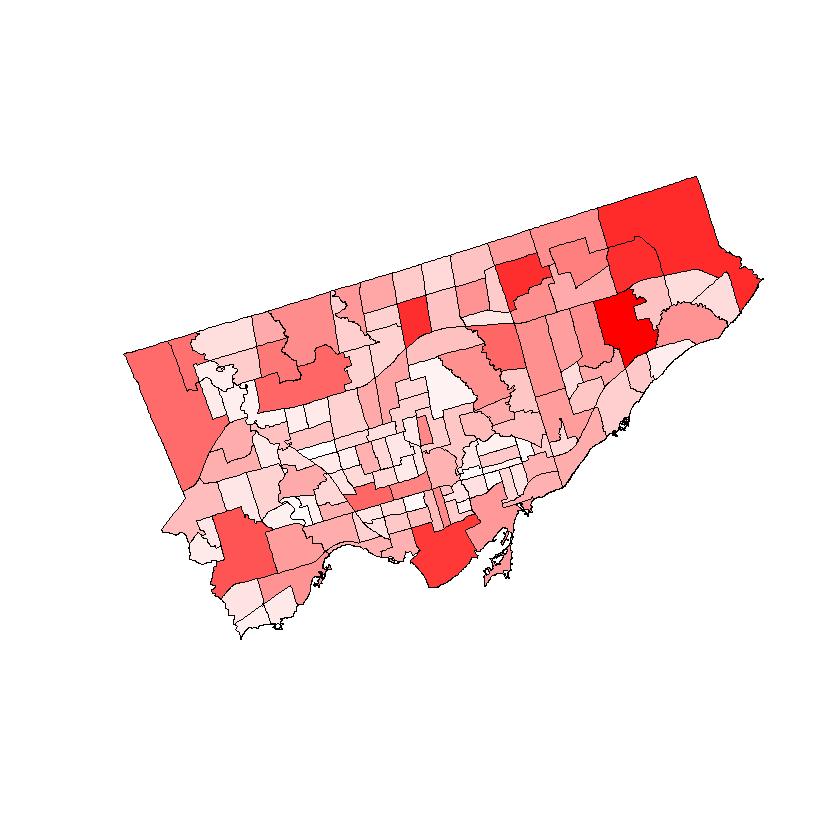

In [21]:
# Set the palette
p <- colorRampPalette(c("white", "red"))(128)
palette(p)

# Scale the total population to the palette
pop <- sh2@data$Total.Population
cols <- (pop - min(pop))/diff(range(pop))*127+1
plot(sh, col=cols)

And there's the glorious result!

Cool. You can see that the population is greater for some of the larger neighbourhoods, notably on the east end and The Waterfront Communities (i.e. condoland)

I'm not crazy about this white-red palette so let's use RColorBrewer's spectral which is one of my faves:

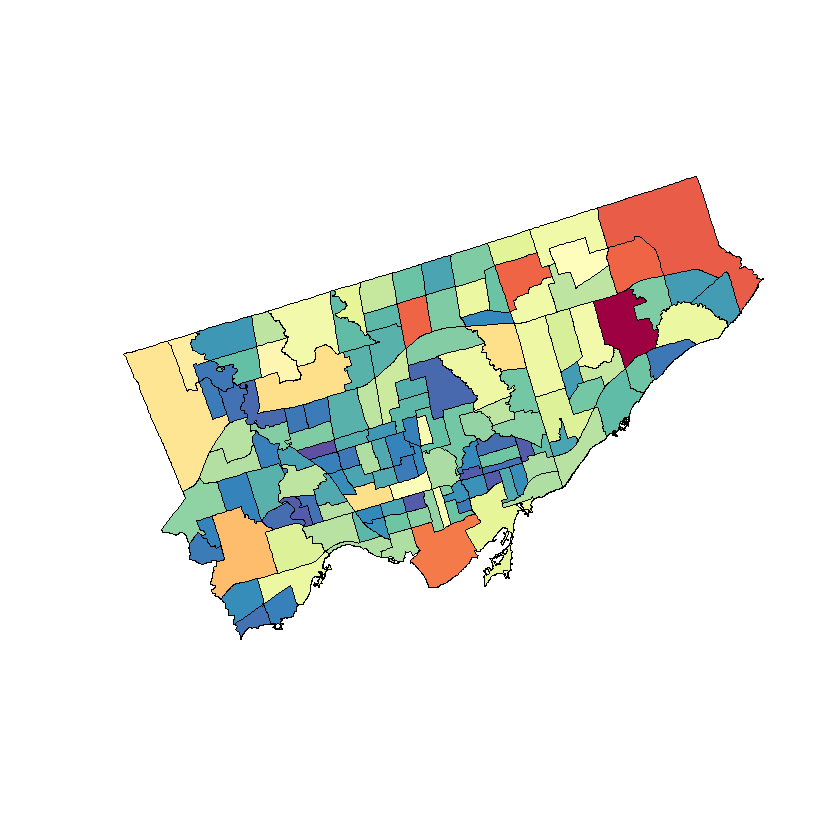

In [22]:
#RColorBrewer, spectral
p <- colorRampPalette(brewer.pal(11, 'Spectral'))(128)
palette(rev(p))
plot(sh2, col=cols)

There, that's better. The dark red neighborhood is Woburn. But we still don't have a legend so this choropleth isn't really telling us anything particularly helpful. And it'd be nice to have the polygons overplotted onto map tiles. So let's use ggmap!

### ggmap
In order to use ggmap we have to decompose the shapefile of polygons into something ggmap can understand (a dataframe). We do this using the fortify command. Then we use ggmap's very handy qmap function which we can just pass a search term to like we would Google Maps, and it fetches the tiles for us automatically and then we overplot the data using standard calls to geom_polygon just like you would in other visualizations using ggplot.

The first polygon call is for the filled shapes and the second is to plot the black borders.

In [37]:
(map <- get_googlemap("waco texas", zoom = 12))

ERROR: [1m[33mError[39m in `get_googlemap()`:[22m
[1m[22m[33m![39m Google now requires an API key; see `ggmap::register_google()`.


In [26]:
#GGPLOT 
points <- fortify(sh, region = 'AREA_S_CD')
# Plot the neighborhoods
toronto <- qmap("Toronto, Ontario", zoom=10, source="osm")
toronto + geom_polygon(aes(x=long,y=lat, group=group, alpha=0.25), data=points, fill='white') +
geom_polygon(aes(x=long,y=lat, group=group), data=points, color='black', fill=NA)

ERROR: [1m[33mError[39m in `get_googlemap()`:[22m
[1m[22m[33m![39m Google now requires an API key; see `ggmap::register_google()`.


Now we merge the demographic data just like we did before, and ggplot takes care of the scaling and legends for us. It's also super easy to use different palettes by using scale_fill_gradient and scale_fill_distiller for ramp palettes and RColorBrewer palettes respectively.

In [24]:
# merge the shapefile data with the social housing data, using the neighborhood ID
points2 <- merge(points, demo, by.x='id', by.y='Neighbourhood.Id', all.x=TRUE)
# Plot
toronto + geom_polygon(aes(x=long,y=lat, group=group, fill=Total.Population), data=points2, color='black') +
  scale_fill_gradient(low='white', high='red')
# Spectral plot
toronto + geom_polygon(aes(x=long,y=lat, group=group, fill=Total.Population), data=points2, color='black') +
  scale_fill_distiller(palette='Spectral') + scale_alpha(range=c(0.5,0.5))

ERROR: Error in eval(expr, envir, enclos): object 'toronto' not found


So there you have it! Hopefully this will be useful for other R users wishing to make nice maps in R using shapefiles, or those who would like to explore using ggmap.

### References & Resources
- code and data on github: https://github.com/mylesmharrison/toronto_neighbourhoods
- Neighbourhood boundaries at Toronto Open Data: http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=04b489fe9c18b210VgnVCM1000003dd60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD
- Demographic data from Well-being Toronto: http://www1.toronto.ca/wps/portal/contentonly?vgnextoid=4482904ade9ea410VgnVCM10000071d60f89RCRD&vgnextchannel=1a66e03bb8d1e310VgnVCM10000071d60f89RCRD